<a href="https://colab.research.google.com/github/sherlock-beep/tf_learn/blob/main/tf_learn6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用tensorflow的tf.data加载数据

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228827136/228813984 [==============================] - 1s 0us/step
/root/.keras/datasets/flower_photos


In [ ]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/tulips


In [ ]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [ ]:
all_image_paths[:10]

['/root/.keras/datasets/flower_photos/roses/8692040971_826614516f_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/14805304536_c321a7b061_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/15381511376_fd743b7330_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/11545123_50a340b473_m.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/19067907051_16d530c7d2.jpg',
 '/root/.keras/datasets/flower_photos/roses/5206847130_ee4bf0e4de_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/16237158409_01913cf918_n.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/7315832212_b0ceeb8de8_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/13857267684_d2a4b2630f_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/2936181186_38ff43492e.jpg']

In [ ]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

attributions

In [ ]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [ ]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [2, 1, 1, 1, 1, 2, 1, 1, 4, 4]


In [ ]:
#加载格式化数据
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/flower_photos/roses/8692040971_826614516f_n.jpg'

In [ ]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [ ]:
#将它解码为图像 tensor
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(227, 320, 3)
<dtype: 'uint8'>


In [ ]:
#调整图片为模型所要求输入数据的shape
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [ ]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.resize(image,[192,192])
  image /= 255.0 #进行归一化
  return image

def load_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

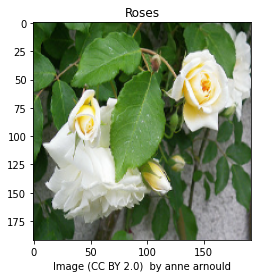

In [ ]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

使用tf.data.Dataset对图片数据集进行处理


In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)


In [ ]:
#对路径图片集进行动态加载和格式化
image_ds = path_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)


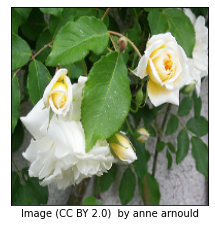

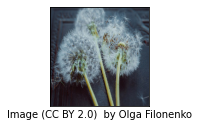

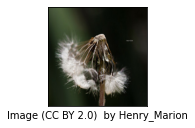

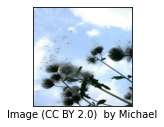

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [ ]:
#对标签数据集进行处理

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [ ]:
print(label_ds)
print(type(label_ds.take(1)))
print(label_ds.take(1))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
for label in label_ds.take(10):

  print(label_names[label.numpy()])

roses
dandelion
dandelion
dandelion
dandelion
roses
dandelion
dandelion
tulips
tulips


In [ ]:
#将图片数据集和标签数据集进行合并
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
all_image_labels

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
  return load_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
BATCH_SIZE = 32
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)
keras_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))


In [ ]:
print(image_batch.shape)
print(label_batch.shape)

(32, 192, 192, 3)
(32,)


In [ ]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [ ]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [ ]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.006694162
max logit: 0.8875462

Shape: (32, 5)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [ ]:
model.fit(ds, epochs=10, steps_per_epoch=steps_per_epoch,verbose=2)

Epoch 1/10
115/115 - 82s - loss: 0.3515 - accuracy: 0.8793 - 82s/epoch - 710ms/step
Epoch 2/10
115/115 - 67s - loss: 0.2816 - accuracy: 0.9060 - 67s/epoch - 583ms/step
Epoch 3/10
115/115 - 66s - loss: 0.2371 - accuracy: 0.9220 - 66s/epoch - 578ms/step
Epoch 4/10
115/115 - 68s - loss: 0.2072 - accuracy: 0.9337 - 68s/epoch - 588ms/step
Epoch 5/10
115/115 - 66s - loss: 0.1855 - accuracy: 0.9429 - 66s/epoch - 577ms/step
Epoch 6/10
115/115 - 66s - loss: 0.1616 - accuracy: 0.9522 - 66s/epoch - 577ms/step
Epoch 7/10
115/115 - 66s - loss: 0.1463 - accuracy: 0.9606 - 66s/epoch - 577ms/step
Epoch 8/10
115/115 - 67s - loss: 0.1322 - accuracy: 0.9644 - 67s/epoch - 585ms/step
Epoch 9/10
115/115 - 66s - loss: 0.1190 - accuracy: 0.9704 - 66s/epoch - 575ms/step
Epoch 10/10
115/115 - 66s - loss: 0.1087 - accuracy: 0.9769 - 66s/epoch - 576ms/step


In [ ]:
c = tf.constant([[4.0, 5.0], [10.0, 1.0]])

# Find the largest value
print(tf.reduce_max(c))
# Find the index of the largest value
print(tf.argmax(c))
# Compute the softmax
print(tf.nn.softmax(c))
print(c)

tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor([1 0], shape=(2,), dtype=int64)
tf.Tensor(
[[2.6894143e-01 7.3105860e-01]
 [9.9987662e-01 1.2339458e-04]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 4.  5.]
 [10.  1.]], shape=(2, 2), dtype=float32)


tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)
tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]]

 [[15 16 17 18 19]
  [20 21 22 23 24]
  [25 26 27 28 29]]], shape=(2, 3, 5), dtype=int32) 

tf.Tensor(
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]], shape=(5, 6), dtype=int32) 

InvalidArgumentError: Input to reshape is a tensor with 30 values, but the requested shape requires a multiple of 7 [Op:Reshape]
